# About

This is the first seminar on track recognition. There are tasks and all necessary information to complete them.

In [48]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt

import os, sys
sys.path.append('../code')

## Generate events with several tracks and noisy hits

This section shows how data sample with 2D straight tracks can be generated. The data sample consist of events (instance/item/sample=event). Each event is a set of hits, which are detected. Some of the hits form track, but some of them are just noise hits.  

For the events generation a **`straight_tracks_generator`** function is used. Parameters of the function:

* **`n_events`**: int, number of generated events.

* **`n_tracks`**: int, number of generated tracks in each event. Tracks will have TrackIDs in range [0, inf).

* **`n_noise`**: int, number of generated random noise hits. Noise hits will have TrackID -1.

* **`sigma`**: float, track's hit generated with error which has normal distribution.
    Sigma is parameter of the distribution.
              
* **`intersection`**: boolean, if False the tracks will not intersect each other.

* **`x_range`**: tuple (min, max, step), range of x values of the hits.

* **`y_range`**: tuple (min, max, step), range of y values of the hits. Only for intersection=False.

* **`k_range`**: tuple (min, max, step), range of k values of the track. y = b + k * x.

* **`b_range`**: tuple (min, max, step), range of b values of the track. y = b + k * x.
* **`random_state`**: int, random state

In [63]:
from utils import straight_tracks_generator
# add random state
events = straight_tracks_generator(n_events=10, n_tracks=3, n_noise=10, sigma=0.1, random_state=43)

events.head()

,EventID,TrackID,X,y
0,0.0,0.0,0.0,-3.699222
1,0.0,0.0,1.0,-5.170481
2,0.0,0.0,2.0,-6.876232
3,0.0,0.0,3.0,-8.514401
4,0.0,0.0,4.0,-9.959391


## Plot Tracks

Function **`plot_straight_tracks`** generates plot of an event with its tracks and noise hits. For hits belonging to the same track linear regression model is uded to estimate track parameters, which are used to plot straight track. Parameters of the function:

* **`event`**: pandas.DataFrame with one event with expected columns `TrackID`, `X`, `y` (`TrackID` column will be used as true labels)

* **`labels`**: numpy.array shape=[n_hits], labels of recognized tracks.

* **`return`**: matplotlib.pyplot object.

In [64]:
# take only the first event
event = events[events.EventID == 0]

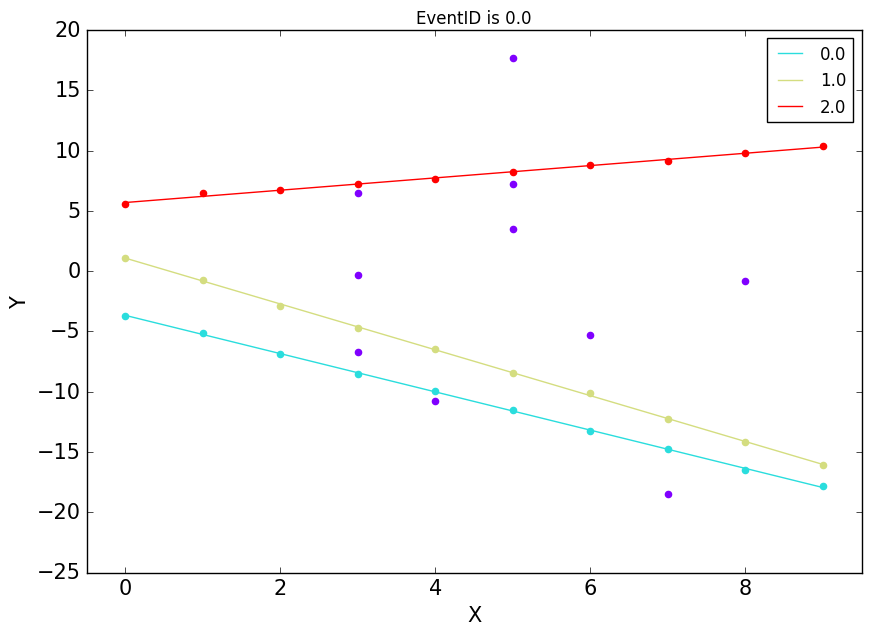

In [65]:
from utils import plot_straight_tracks

plot_straight_tracks(event, labels=None)
plt.xlim(-0.5, 9.5);

# Tracks Recognition Methods

Several methods of tracks recognition, considered at the lecture, are introduced in this section. Each method is a `class` and has `fit` method which finds hits belonging to a track and estimates parameters of this track.

#### Take the first event with all its tracks and extraxt `x` and `y` coordinates of all hits

In [66]:
X = event.X.values
y = event.y.values

## Simple Template Matching

The **`SimpleTemplateMatching`** class is a simple realization of a Template Matching paradigm for the straight tracks in 2D. Parameters:

* **`n_hits`**: int, min number of hits to consider the track recognized.

* **`window_width`**: float, width of a searching window to consider the hists in the window to be belonged to the track.

In [67]:
from TemplateMatching import SimpleTemplateMatching

stm = SimpleTemplateMatching(8, 1.0)
stm.fit(X, y)

params = stm.tracks_params_
labels = stm.labels_

In [7]:
labels

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  0.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2., -1., -1., -1., -1., -1., -1., -1., -1.,  2., -1.])

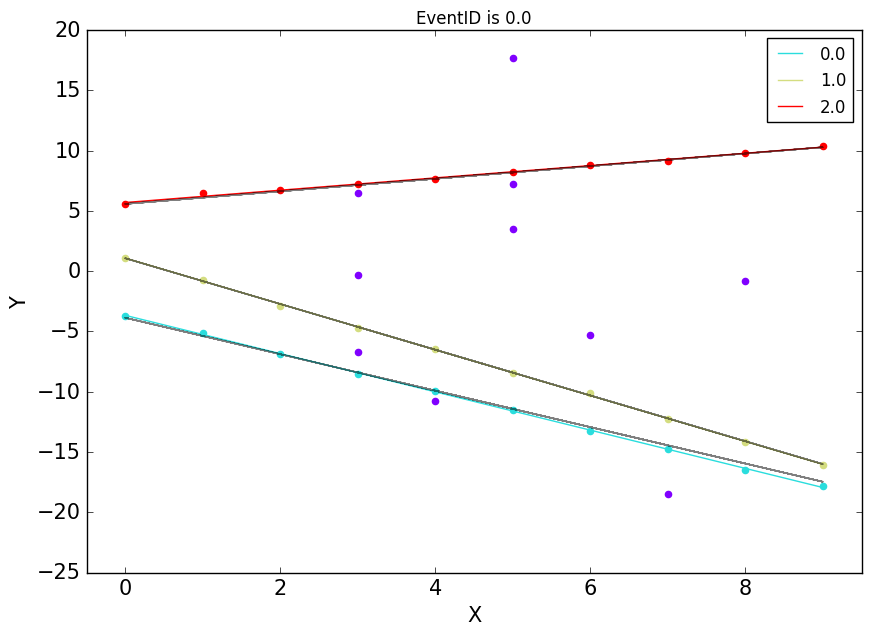

In [68]:
plot_straight_tracks(event, labels)
plt.xlim(-0.5, 9.5);

# RANSAC

The **`RANSACTracker`** class is a wrapper over the scikit-learn [RANSACRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html). Parameters:

* **`n_tracks`**: number of searched tracks
* **`min_hits`**: minimum number of hits in a track
* **`regressor`**: a scikit-learn RANSACRegressor object

In [9]:
from sklearn.linear_model import RANSACRegressor
from RANSAC import RANSACTracker

sk_ransac = RANSACRegressor(min_samples=3, max_trials=1000, residual_threshold=1.)
ransac = RANSACTracker(3, 3, regressor=sk_ransac)
ransac.fit(X, y)

labels = ransac.labels_

In [10]:
labels

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -1., -1.,  1.,  0., -1., -1., -1., -1.,  0., -1.])

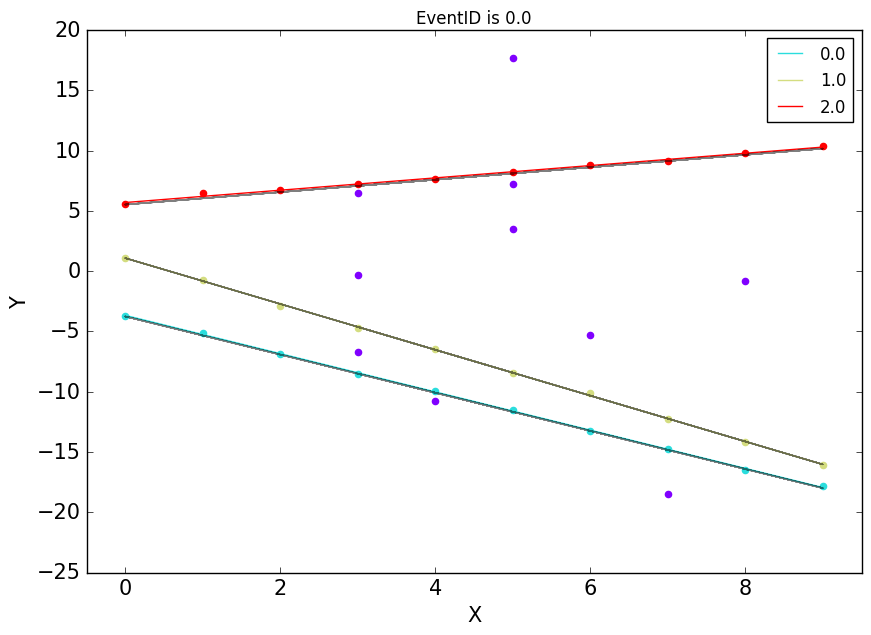

In [11]:
plot_straight_tracks(event, labels)
plt.xlim(-0.5, 9.5);

# Retina

The **`Retina2DTrackerTwo`** class is realization of the retina idea for the tracks reconstruction in 2D. Parameters:

* **`n_tracks`**: int, number of tracks searching for.

* **`residuals_threshold`**: float, residual threshold value for a hit to be considered as a track's hit.

* **`param sigma`**: float, sigma value for the retina function.

* **`param min_hits`**: int, min number of hits in a track.

In [12]:
from retina import Retina2DTrackerTwo

rt = Retina2DTrackerTwo(n_tracks=3, residuals_threshold=1.0, sigma=0.2, min_hits=3)
rt.fit(X, y)
labels = rt.labels_

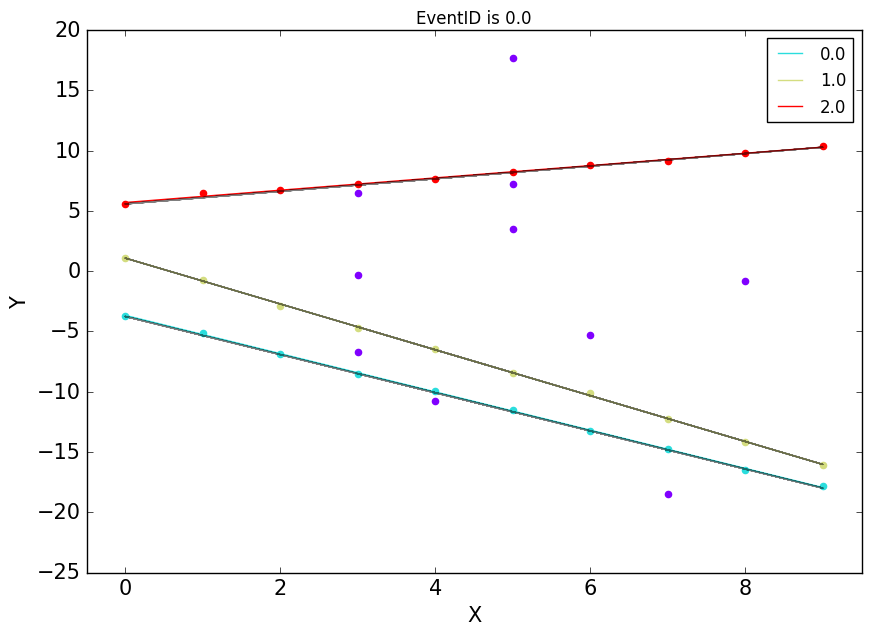

In [13]:
plot_straight_tracks(event, labels)
plt.xlim(-0.5, 9.5);

# DenbyPeterson

The **`DenbyPeterson`** class is a simple realization of the Denby-Peterson method of the tracks recognition. Parameters:

* **`n_iter`**: int, number of iteration.

* **`cos_degree`**: int, degree of the cosine value for the angle between the two neurons.

* **`alpha`**: float, multiplier of the penalty function against bifurcations.

* **`delta`**: float, multiplier of the penalty function to balance number of active neurons against number of hits.

* **`temperature`**: float, parameter in the neuron's state updating rule.

* **`temperature_decay_rate`**: float, decay rate of the temperature during the network optimization.

* **`max_cos`**: float, max cosine value for the angle between the two neurons. The neurons with larger values will be removed after the network optimization.

* **`state_threshold`**: float, is sate of a neuron is greater than this value, the neuron will marked as active.

* **`min_hits`**: int, min number of hits in a track candidate.

* **`save_stages`**: boolean, if True, the neurons states will be saved after each iteration.

In [14]:
from DenbyPeterson import DenbyPeterson

dp = DenbyPeterson(n_iter=10, 
                   cos_degree=1, 
                   alpha=0.00, 
                   delta=0.00, 
                   temperature=1, 
                   temperature_decay_rate=1., 
                   max_cos=-0.9,
                   state_threshold=0.5,
                   min_hits=3,
                   save_stages=True)
dp.fit(X, y)

satets = dp.states_
states_after_cut = dp.states_after_cut_
labels = dp.labels_


energy_stages = dp.energy_stages_

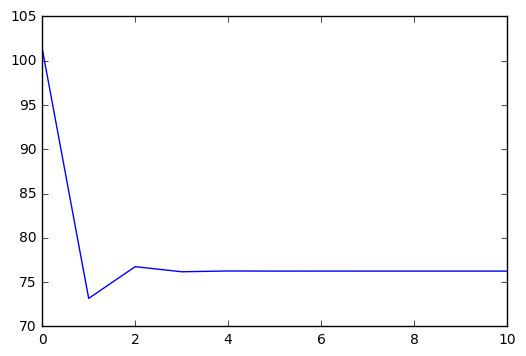

In [15]:
plt.plot(energy_stages);

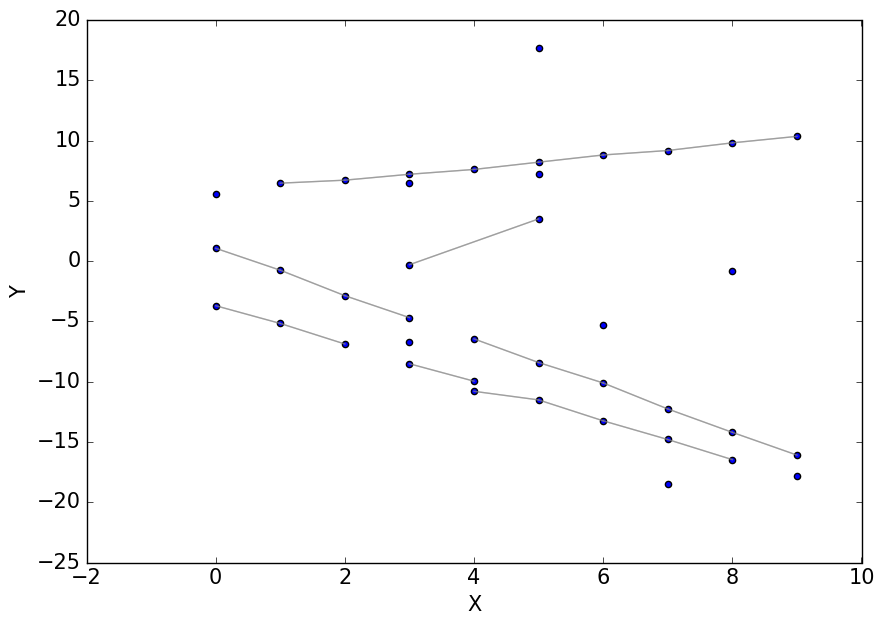

In [16]:
from DenbyPeterson import plot_neural_net

plot_neural_net(X, y, states_after_cut, 0.5)

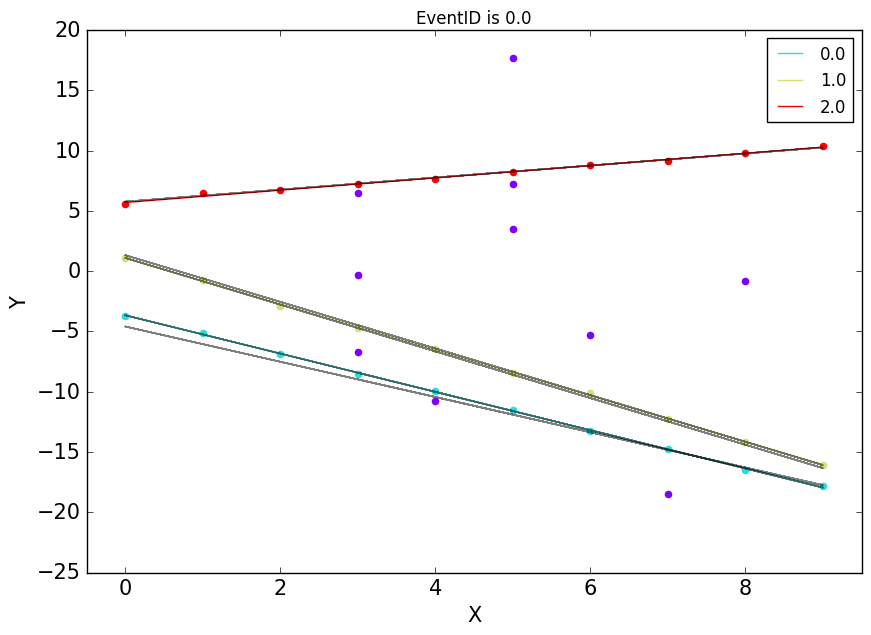

In [17]:
plot_straight_tracks(event, labels)
plt.xlim(-0.5, 9.5);

# Quality Metrics

This part presents metrics which are used to measure quality of tracks recognition

## Hits Matching

The **`HitsMatchingEfficiency`** class calculates tracks efficiencies, reconstruction efficiency, ghost rate and clone rate for one event using hits matching approach. Parameters:

* **`eff_threshold`**: float, threshold value on a track efficiency to consider a track as a reconstructed one.

In [18]:
from metrics import HitsMatchingEfficiency

hme = HitsMatchingEfficiency()
hme.fit(event, labels)

# after fit we have all quality values as the following properties:
print 'tracks eff:\t', hme.efficiencies_
print 'average eff:\t', hme.avg_efficiency_
print 'reconstruction eff:\t', hme.reconstruction_efficiency_
print 'ghost rate:\t', hme.ghost_rate_
print 'clone rate:\t', hme.clone_rate_

tracks eff:	[ 1.   0.8  1.   1.   1. ]
average eff:	0.96
reconstruction eff:	1.0
ghost rate:	0.0
clone rate:	0.666666666667


## Parameters Matching

The **`ParameterMatchingEfficiency`** class calculates tracks efficiencies, reconstruction efficiency, ghost rate and clone rate for one event using parameters matching approach. Parameters:

* **`delta_k`**: float, maximum abs difference between a true track k value and a recognized one to consider the track to be reconstructed.

* **`delta_b`**: float, maximum abs difference between a true track b value and a recognized one to consider the track to be reconstructed.

In [19]:
from metrics import ParameterMatchingEfficiency

pme = ParameterMatchingEfficiency(delta_k = .2, delta_b=1.)
pme.fit(event, labels)

# after fit we have all quality values as the following properties
print 'reconstruction eff:\t', pme.reconstruction_efficiency_
print 'ghost rate:\t', pme.ghost_rate_
print 'clone rate:\t', pme.clone_rate_

reconstruction eff:	1.0
ghost rate:	0.0
clone rate:	0.666666666667


## Quality on all events

To test a track recognition method you can use the following function:

In [20]:
from copy import copy
from metrics import HitsMatchingEfficiency, ParameterMatchingEfficiency

def get_quality_meatrics(events, model):
    
    results = pandas.DataFrame(columns=['EventID', 'HmAvgEff',
                                        'HmRecoEff', 'HmGhostRate', 'HmCloneRate', 
                                        'PmRecoEff', 'PmGhostRate', 'PmCloneRate'])

    for event_id in numpy.unique(events.EventID.values):
        event = events[events.EventID == event_id]
        x = event.X.values
        y = event.y.values
        
        model_object = copy(model)
        model_object.fit(x, y)
        labels = model_object.labels_

        hme = HitsMatchingEfficiency()
        hme.fit(event, labels)

        pme = ParameterMatchingEfficiency(delta_k = 0.4, delta_b=2.)
        pme.fit(event, labels)

        results.loc[len(results)] = [event_id, hme.avg_efficiency_, 
                                     hme.reconstruction_efficiency_, hme.ghost_rate_, hme.clone_rate_, 
                                     pme.reconstruction_efficiency_, pme.ghost_rate_, pme.clone_rate_]
        
    return results

In [21]:
results = get_quality_meatrics(events, model=stm)

In [22]:
results.head()

,EventID,HmAvgEff,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,0.0,0.939394,1.000000,0.0,0.0,1.000000,0.0,0.0
1,1.0,0.888889,1.000000,0.0,0.0,1.000000,0.0,0.0
2,2.0,0.827778,1.000000,0.0,0.0,1.000000,0.0,0.0
3,3.0,0.906061,1.000000,0.0,0.0,1.000000,0.0,0.0
4,4.0,0.767045,0.666667,0.0,0.0,0.666667,0.0,0.0


In [23]:
results.mean(axis=0)

EventID        4.500000
HmAvgEff       0.861319
HmRecoEff      0.933333
HmGhostRate    0.000000
HmCloneRate    0.033333
PmRecoEff      0.966667
PmGhostRate    0.000000
PmCloneRate    0.000000
dtype: float64

## Supporting function

You can use the following function to plot your results.

In [24]:
def plot_report(report, x_column):
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 2)
    plt.plot(report[x_column].values, report['PmRecoEff'].values, linewidth=4, label='Reco Eff')
    plt.plot(report[x_column].values, report['PmGhostRate'].values, linewidth=4, label='Ghost Rate')
    plt.plot(report[x_column].values, report['PmCloneRate'].values, linewidth=4, label='Clone Rate')
    plt.legend(loc='best', prop={'size':12})
    plt.xlabel(x_column, size=12)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title('Parameters Matching', size=12)
    
    plt.subplot(1, 2, 1)
    plt.plot(report[x_column].values, report['HmRecoEff'].values, linewidth=4, label='Reco Eff')
    plt.plot(report[x_column].values, report['HmGhostRate'].values, linewidth=4, label='Ghost Rate')
    plt.plot(report[x_column].values, report['HmCloneRate'].values, linewidth=4, label='Clone Rate')
    plt.legend(loc='best', prop={'size':12})
    plt.xlabel(x_column, size=12)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title('Hits Matching', size=12)
    
    plt.show()

# Tasks

Below you will find tasks and examples how to do them.

**Note: take into account that the Denby-Peterson method takes a lot of time.**

**Have fun!**

## Task 1 (1 points)

Find optimal parameters for the four different tracks recognition models. Try to improve Reconstruction Efficiecies with reducing Ghost and Clone Rates at the same time.

Note: We intentionally set the wrong parameters, so you have all chances to improve the tracks recognition qualities for all models.

In [405]:
events = straight_tracks_generator(n_events=100, n_tracks=3, n_noise=10, sigma=0.5)
events.head()

,EventID,TrackID,X,y
0,0.0,0.0,0.0,4.167304
1,0.0,0.0,1.0,5.429206
2,0.0,0.0,2.0,5.464420
3,0.0,0.0,3.0,5.981303
4,0.0,0.0,4.0,7.186234


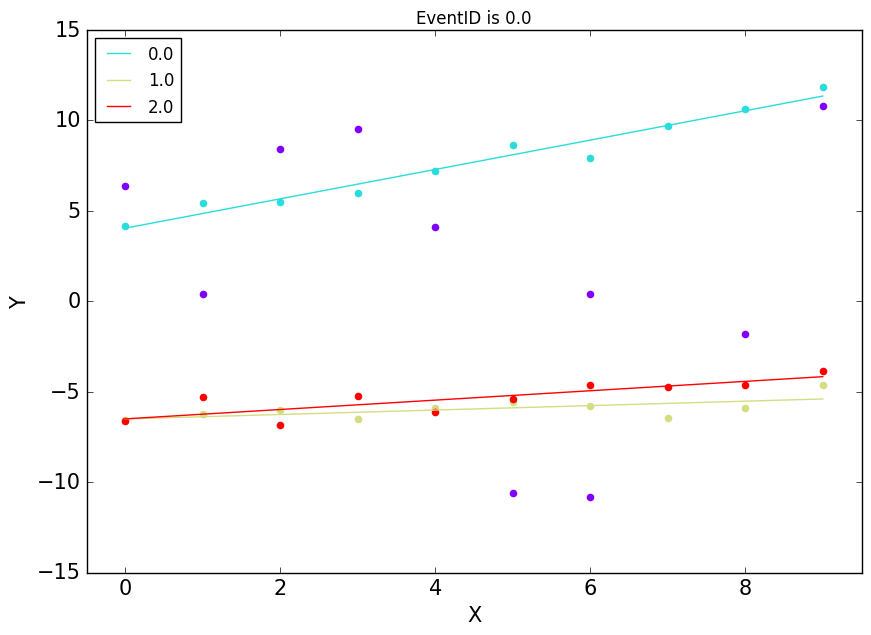

In [406]:
event = events[events.EventID == 0]
plot_straight_tracks(event, labels=None)
plt.xlim(-0.5, 9.5);

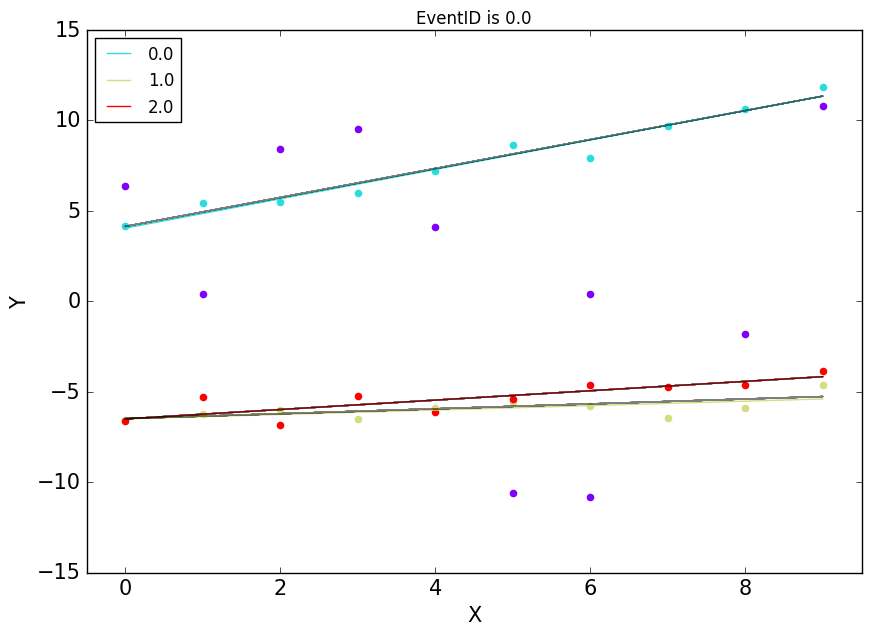

In [425]:
stm = SimpleTemplateMatching(6, 0.5)
stm.fit(X, y)

params = stm.tracks_params_
labels = stm.labels_
plot_straight_tracks(event, labels)
plt.xlim(-0.5, 9.5);

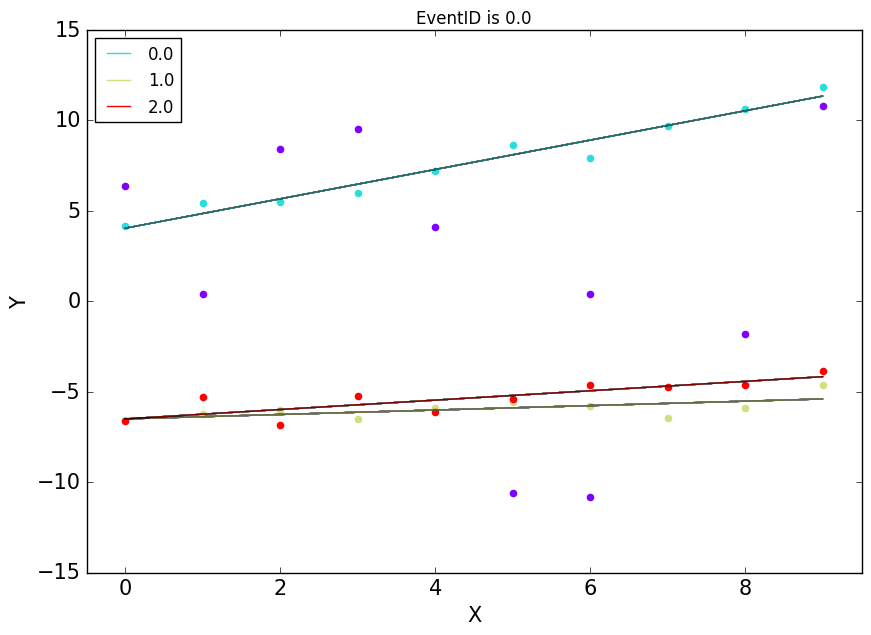

In [419]:
sk_ransac = RANSACRegressor(min_samples=3, max_trials=100, residual_threshold=0.5)
ransac = RANSACTracker(n_tracks=3, min_hits=6, regressor=sk_ransac)
ransac.fit(X, y)
labels = ransac.labels_
plot_straight_tracks(event, labels)
plt.xlim(-0.5, 9.5);

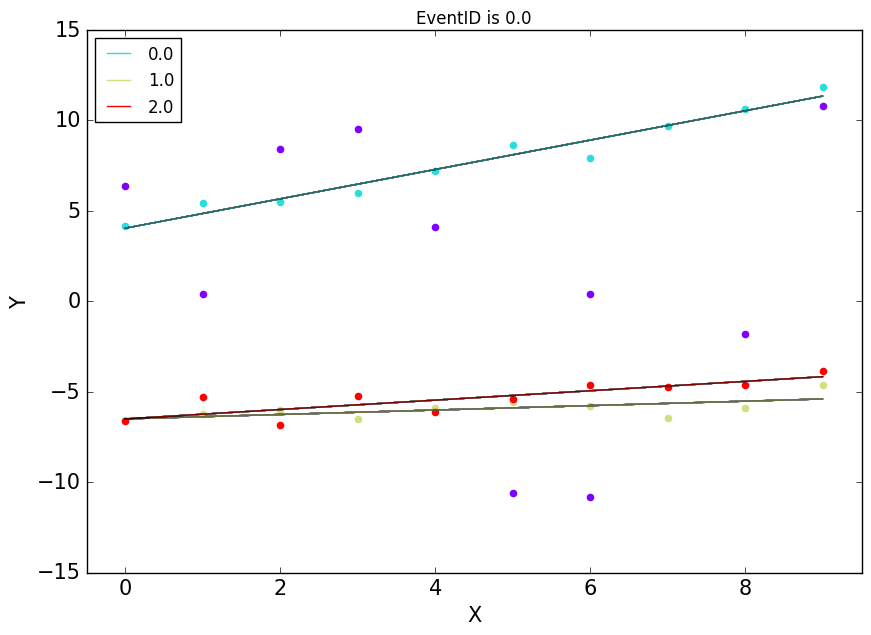

In [420]:
rt = Retina2DTrackerTwo(n_tracks=3, residuals_threshold=0.5, sigma=0.1, min_hits=6)
rt.fit(X, y)
labels = rt.labels_
plot_straight_tracks(event, labels)
plt.xlim(-0.5, 9.5);

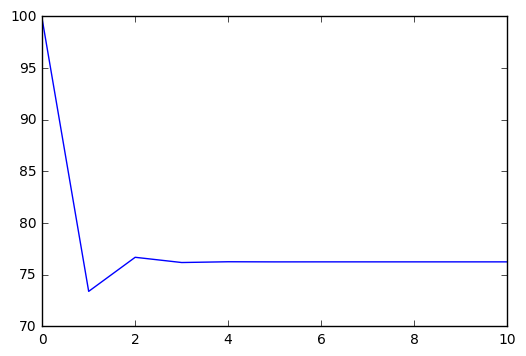

In [412]:
dp = DenbyPeterson(n_iter=10, 
                   cos_degree=1., 
                   alpha=0.00, 
                   delta=0.00, 
                   temperature=1, 
                   temperature_decay_rate=1., 
                   max_cos=0.9,
                   state_threshold=0.5,
                   min_hits=6,
                   save_stages=True)
dp.fit(X, y)
labels = dp.labels_
satets = dp.states_
states_after_cut = dp.states_after_cut_
energy_stages = dp.energy_stages_
plt.plot(energy_stages);

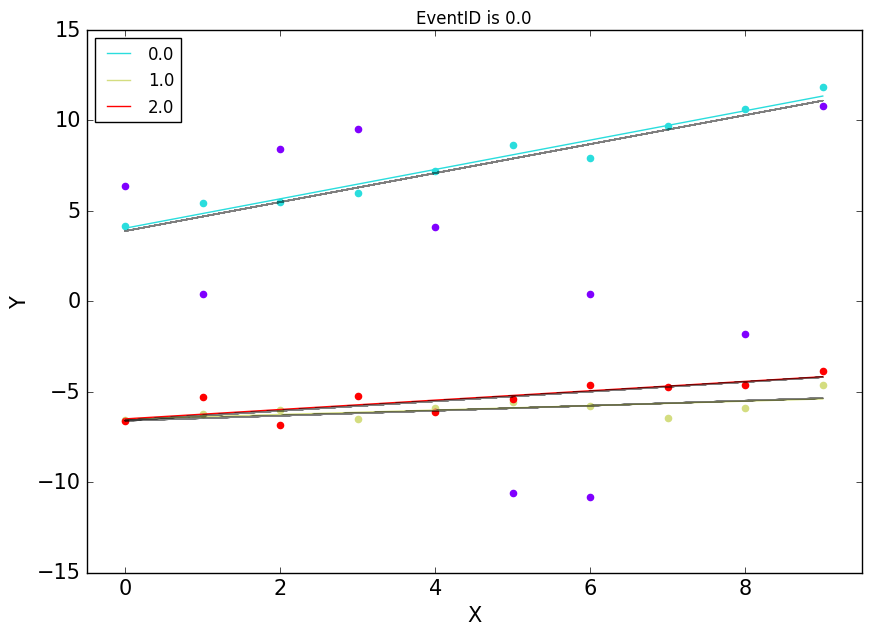

In [413]:
plot_straight_tracks(event, labels)
plt.xlim(-0.5, 9.5);

In [426]:
%%time
results_stm = get_quality_meatrics(events, model=stm)
results_ransac = get_quality_meatrics(events, model=ransac)
results_rt = get_quality_meatrics(events, model=rt)
results_dp = get_quality_meatrics(events, model=dp)

CPU times: user 7min 9s, sys: 3.87 s, total: 7min 13s
Wall time: 7min 21s


In [427]:
columns=['HmRecoEff', 'HmGhostRate', 'HmCloneRate', 'PmRecoEff', 'PmGhostRate', 'PmCloneRate']
total_report = pandas.DataFrame(columns=columns, index=['stm', 'ransac', 'rt', 'dp'])

total_report.loc['stm'] = list(results_stm[columns].mean(axis=0).values)
total_report.loc['ransac'] = list(results_ransac[columns].mean(axis=0).values)
total_report.loc['rt'] = list(results_rt[columns].mean(axis=0).values)
total_report.loc['dp'] = list(results_dp[columns].mean(axis=0).values)
total_report

,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
stm,0.963333,0.04,0.113333,0.973333,0.04,0.103333
ransac,0.943333,0.02,0.00333333,0.936667,0.0166667,0.0133333
rt,0.656667,0.0266667,0.00333333,0.66,0.0233333,0.00333333
dp,0.44,0.02,0.0233333,0.386667,0.09,0.00666667


## Task 2 (2 points)

Study the dependence between noise rate of the tracks and quality metrics for the different models. Plot qualitiy curves (see example below) for the each model.

Note: for the noise rate regulation use **`sigma`** parameter of the **`straight_tracks_generator`** function. For each **`sigma`** value try to tune the models optimally. For the other parameters you can take your own values. Use the example below.

In [525]:
columns=['sigma', 'HmRecoEff', 'HmGhostRate', 'HmCloneRate', 'PmRecoEff', 'PmGhostRate', 'PmCloneRate']

sigmas = [0.1, 0.5, 1., 2., 3., 4., 5.]

In [447]:
report = pandas.DataFrame(columns=columns)

for sigma in sigmas:
    events = straight_tracks_generator(n_events=100, n_tracks=3, n_noise=10, sigma=sigma)
    stm = SimpleTemplateMatching(6, sigma)
    results_stm = get_quality_meatrics(events, model=stm)
    
    report.loc[len(report)] = [sigma] + list(results_stm[columns[1:]].mean(axis=0).values)

In [448]:
report

,sigma,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,0.1,0.986667,0.000000,0.000000,0.986667,0.000000,0.000000
1,0.5,0.943333,0.046667,0.126667,0.936667,0.080000,0.100000
2,1.0,0.896667,0.203333,0.140000,0.746667,0.443333,0.050000
3,2.0,0.753333,0.463333,0.140000,0.383333,0.950000,0.023333
4,3.0,0.590000,0.650000,0.076667,0.253333,1.063333,0.000000
5,4.0,0.506667,0.743333,0.056667,0.150000,1.156667,0.000000
6,5.0,0.430000,0.830000,0.040000,0.133333,1.166667,0.000000


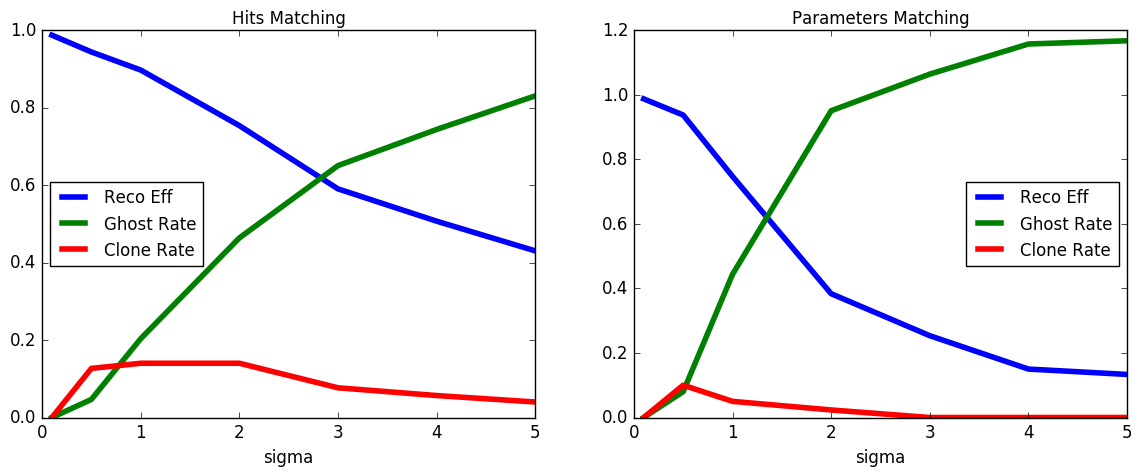

In [451]:
plot_report(report, 'sigma')

In [452]:
report = pandas.DataFrame(columns=columns)

for sigma in sigmas:
    events = straight_tracks_generator(n_events=100, n_tracks=3, n_noise=10, sigma=sigma)
    sk_ransac = RANSACRegressor(min_samples=3, max_trials=100, residual_threshold=sigma)
    ransac = RANSACTracker(n_tracks=3, min_hits=6, regressor=sk_ransac)
    results_ran = get_quality_meatrics(events, model=ransac)
    
    report.loc[len(report)] = [sigma] + list(results_ran[columns[1:]].mean(axis=0).values)

In [453]:
report

,sigma,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,0.1,0.926667,0.000000,0.000000,0.926667,0.000000,0.000000
1,0.5,0.913333,0.026667,0.006667,0.903333,0.036667,0.006667
2,1.0,0.850000,0.103333,0.003333,0.776667,0.170000,0.010000
3,2.0,0.690000,0.253333,0.003333,0.513333,0.430000,0.003333
4,3.0,0.436667,0.460000,0.003333,0.280000,0.620000,0.000000
5,4.0,0.316667,0.510000,0.003333,0.213333,0.616667,0.000000
6,5.0,0.303333,0.533333,0.000000,0.130000,0.706667,0.000000


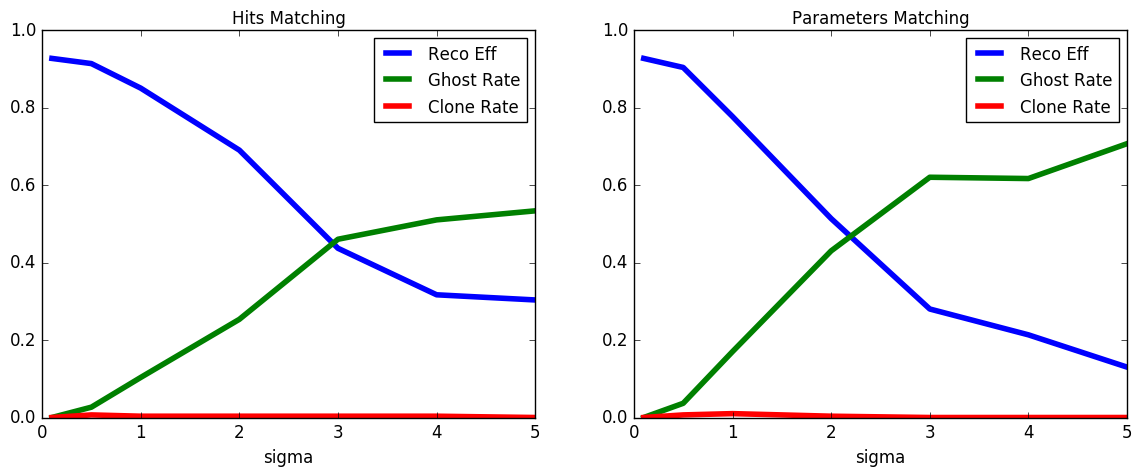

In [454]:
plot_report(report, 'sigma')

In [455]:
report = pandas.DataFrame(columns=columns)

for sigma in sigmas:
    events = straight_tracks_generator(n_events=100, n_tracks=3, n_noise=10, sigma=sigma)
    rt = Retina2DTrackerTwo(n_tracks=3, residuals_threshold=sigma, sigma=0.1, min_hits=6)
    results_rt = get_quality_meatrics(events, model=rt)
    
    report.loc[len(report)] = [sigma] + list(results_rt[columns[1:]].mean(axis=0).values)

In [456]:
report

,sigma,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,0.1,0.980000,0.000000,0.000000,0.980000,0.000000,0.000000
1,0.5,0.733333,0.013333,0.003333,0.716667,0.030000,0.003333
2,1.0,0.586667,0.093333,0.003333,0.486667,0.183333,0.013333
3,2.0,0.436667,0.256667,0.013333,0.293333,0.400000,0.013333
4,3.0,0.336667,0.400000,0.010000,0.166667,0.576667,0.003333
5,4.0,0.346667,0.473333,0.010000,0.163333,0.666667,0.000000
6,5.0,0.223333,0.583333,0.006667,0.090000,0.723333,0.000000


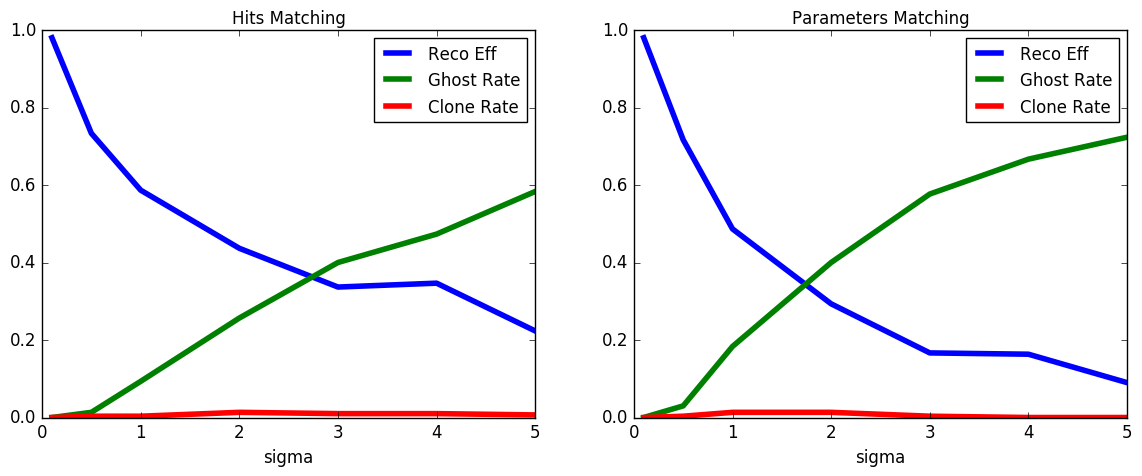

In [457]:
plot_report(report, 'sigma')

In [461]:
report = pandas.DataFrame(columns=columns)

for sigma in sigmas:
    events = straight_tracks_generator(n_events=100, n_tracks=3, n_noise=10, sigma=sigma)
    dp = DenbyPeterson(n_iter=10, 
                   cos_degree=1., 
                   alpha=0.00, 
                   delta=0.00, 
                   temperature=1, 
                   temperature_decay_rate=1., 
                   max_cos=0.9,
                   state_threshold=0.5,
                   min_hits=6,
                   save_stages=True)
    results_dp = get_quality_meatrics(events, model=dp)
    
    report.loc[len(report)] = [sigma] + list(results_dp[columns[1:]].mean(axis=0).values)

In [462]:
report

,sigma,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,0.1,0.750000,0.030000,0.016667,0.676667,0.110000,0.010000
1,0.5,0.406667,0.036667,0.010000,0.356667,0.086667,0.010000
2,1.0,0.236667,0.046667,0.003333,0.170000,0.113333,0.003333
3,2.0,0.113333,0.063333,0.000000,0.040000,0.136667,0.000000
4,3.0,0.053333,0.103333,0.000000,0.036667,0.116667,0.003333
5,4.0,0.066667,0.080000,0.000000,0.023333,0.123333,0.000000
6,5.0,0.050000,0.056667,0.000000,0.010000,0.096667,0.000000


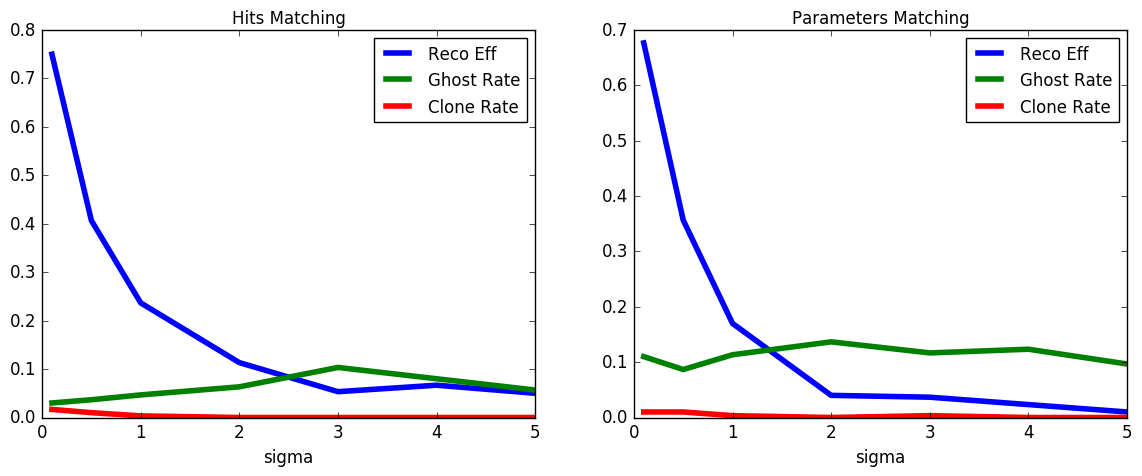

In [463]:
plot_report(report, 'sigma')

## Task 3 (2 points)

Explore how the quality metrics depends on the number of tracks in one event for the different track recognition models. Plot qualitiy curves (see example below) for each model.

Note: Use **`n_tracks`** parameter of **`straight_tracks_generator`** function to change number of tracks per event. For each **`n_tracks`** value try to tune the models optimally. For the other parameters you can take your own values. 

In [552]:
columns=['NTracks', 'HmRecoEff', 'HmGhostRate', 'HmCloneRate', 'PmRecoEff', 'PmGhostRate', 'PmCloneRate']

ns_tracks = [1, 2, 3, 4, 5]

In [465]:
report = pandas.DataFrame(columns=columns)

for n_tracks in ns_tracks:
    events = straight_tracks_generator(n_events=100, n_tracks=n_tracks, n_noise=10, sigma=0.5)
    stm = SimpleTemplateMatching(6, 0.5)
    results_stm = get_quality_meatrics(events, model=stm)
    
    report.loc[len(report)] = [n_tracks] + list(results_stm[columns[1:]].mean(axis=0).values)

In [466]:
report

,NTracks,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,1.0,1.000,0.020000,0.020000,1.000000,0.010000,0.030000
1,2.0,0.965,0.020000,0.075000,0.975000,0.030000,0.055000
2,3.0,0.970,0.046667,0.096667,0.956667,0.073333,0.083333
3,4.0,0.945,0.102500,0.140000,0.930000,0.150000,0.107500
4,5.0,0.894,0.148000,0.136000,0.886000,0.148000,0.144000


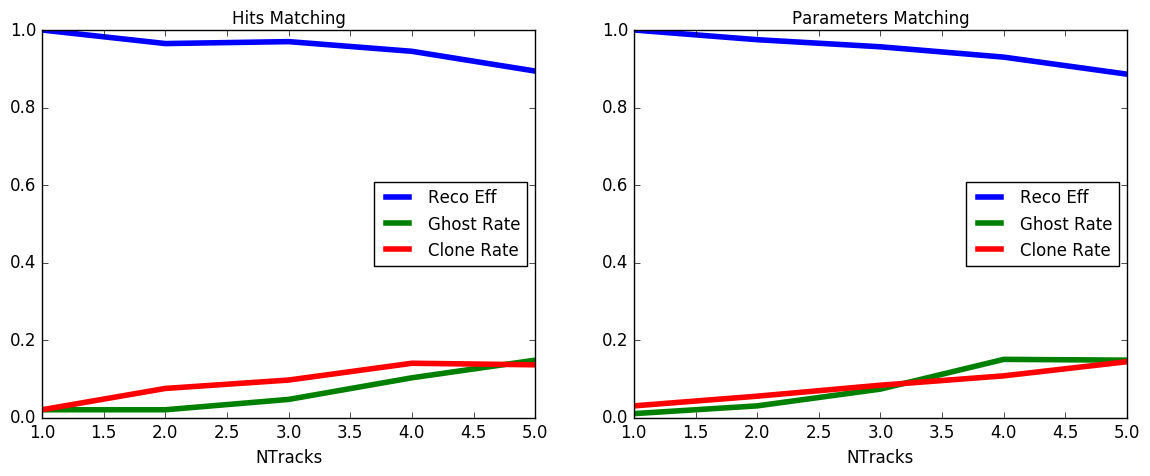

In [467]:
plot_report(report, 'NTracks')

In [468]:
report = pandas.DataFrame(columns=columns)

for n_tracks in ns_tracks:
    events = straight_tracks_generator(n_events=100, n_tracks=n_tracks, n_noise=10, sigma=0.5)
    sk_ransac = RANSACRegressor(min_samples=3, max_trials=100, residual_threshold=0.5)
    ransac = RANSACTracker(n_tracks=n_tracks, min_hits=6, regressor=sk_ransac)
    results_ran = get_quality_meatrics(events, model=ransac)
    
    report.loc[len(report)] = [n_tracks] + list(results_ran[columns[1:]].mean(axis=0).values)

In [469]:
report

,NTracks,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,1.0,0.9900,0.010000,0.000,0.980000,0.0200,0.000000
1,2.0,0.9700,0.005000,0.000,0.965000,0.0050,0.005000
2,3.0,0.9400,0.013333,0.010,0.936667,0.0200,0.006667
3,4.0,0.9075,0.040000,0.000,0.897500,0.0425,0.007500
4,5.0,0.8420,0.066000,0.004,0.850000,0.0500,0.012000


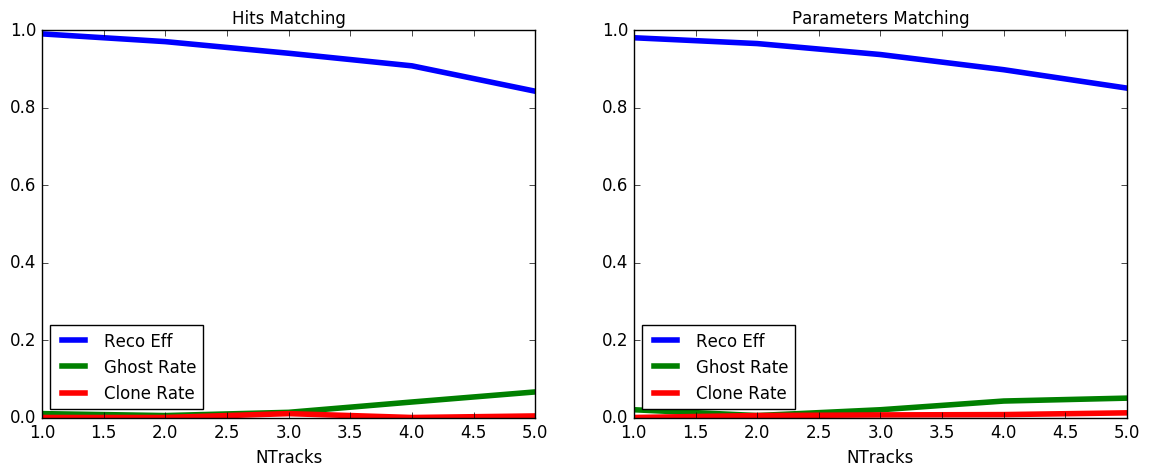

In [470]:
plot_report(report, 'NTracks')

In [471]:
report = pandas.DataFrame(columns=columns)

for n_tracks in ns_tracks:
    events = straight_tracks_generator(n_events=100, n_tracks=n_tracks, n_noise=10, sigma=0.5)
    rt = Retina2DTrackerTwo(n_tracks=n_tracks, residuals_threshold=0.5, sigma=0.1, min_hits=6)
    results_rt = get_quality_meatrics(events, model=rt)
    
    report.loc[len(report)] = [n_tracks] + list(results_rt[columns[1:]].mean(axis=0).values)

In [472]:
report

,NTracks,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,1.0,0.740000,0.020000,0.000000,0.740,0.020000,0.000000
1,2.0,0.700000,0.025000,0.000000,0.700,0.025000,0.000000
2,3.0,0.656667,0.026667,0.016667,0.660,0.023333,0.016667
3,4.0,0.657500,0.052500,0.010000,0.665,0.040000,0.015000
4,5.0,0.548000,0.062000,0.004000,0.556,0.052000,0.006000


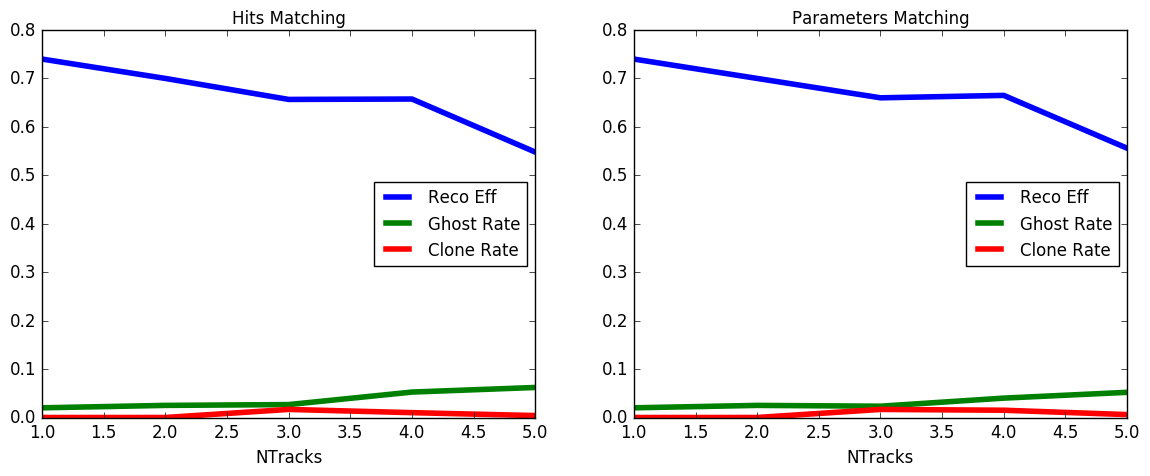

In [473]:
plot_report(report, 'NTracks')

In [555]:
report = pandas.DataFrame(columns=columns)

for n_tracks in ns_tracks:
    events = straight_tracks_generator(n_events=100, n_tracks=n_tracks, n_noise=10, sigma=0.5)
    dp = DenbyPeterson(n_iter=10, 
                   cos_degree=1., 
                   alpha=0.00, 
                   delta=0.00, 
                   temperature=1, 
                   temperature_decay_rate=1., 
                   max_cos=0.9,
                   state_threshold=0.5,
                   min_hits=6,
                   save_stages=True)
    results_dp = get_quality_meatrics(events, model=dp)
    
    report.loc[len(report)] = [n_tracks] + list(results_dp[columns[1:]].mean(axis=0).values)

In [557]:
report

,NTracks,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,1.0,0.640000,0.0600,0.000000,0.600000,0.100000,0.000000
1,2.0,0.540000,0.0100,0.000000,0.460000,0.090000,0.000000
2,3.0,0.483333,0.0300,0.006667,0.426667,0.086667,0.006667
3,4.0,0.370000,0.0425,0.012500,0.332500,0.085000,0.007500
4,5.0,0.286000,0.0620,0.004000,0.270000,0.078000,0.004000


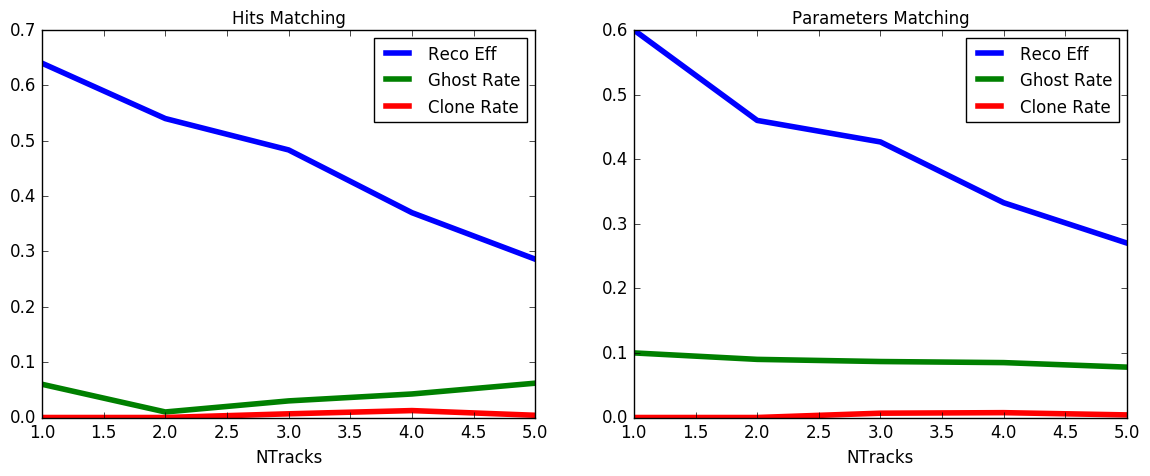

In [558]:
plot_report(report, 'NTracks')

## Task 4 (2 points)

Explore how the number of noisy hits per one event influences the quality metrics for the different models. Plot qualitiy curves (see example below) for each model.

Note: use **`n_noise`** parameter of **`straight_tracks_generator`** function to change number of noisy hits per event. For each **`n_noise`** value try to tune the models optimally. For the other parameters you can take your own values. 

In [545]:
columns=['NNoise', 'HmRecoEff', 'HmGhostRate', 'HmCloneRate', 'PmRecoEff', 'PmGhostRate', 'PmCloneRate']

ns_noise = [0, 5, 10, 20, 30, 40, 50]

In [475]:
report = pandas.DataFrame(columns=columns)

for n_noise in ns_noise:
    events = straight_tracks_generator(n_events=100, n_tracks=3, n_noise=n_noise, sigma=0.5)
    stm = SimpleTemplateMatching(6, 0.5)
    results_stm = get_quality_meatrics(events, model=stm)
    
    report.loc[len(report)] = [n_noise] + list(results_stm[columns[1:]].mean(axis=0).values)

In [476]:
report

,NNoise,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,0.0,0.960000,0.003333,0.040000,0.946667,0.026667,0.030000
1,5.0,0.953333,0.026667,0.086667,0.973333,0.036667,0.056667
2,10.0,0.980000,0.053333,0.120000,0.973333,0.073333,0.106667
3,20.0,0.980000,0.203333,0.150000,0.960000,0.223333,0.150000
4,30.0,0.913333,0.523333,0.163333,0.916667,0.486667,0.196667
5,40.0,0.930000,0.866667,0.180000,0.950000,0.743333,0.283333
6,50.0,0.876667,1.306667,0.150000,0.930000,1.083333,0.320000


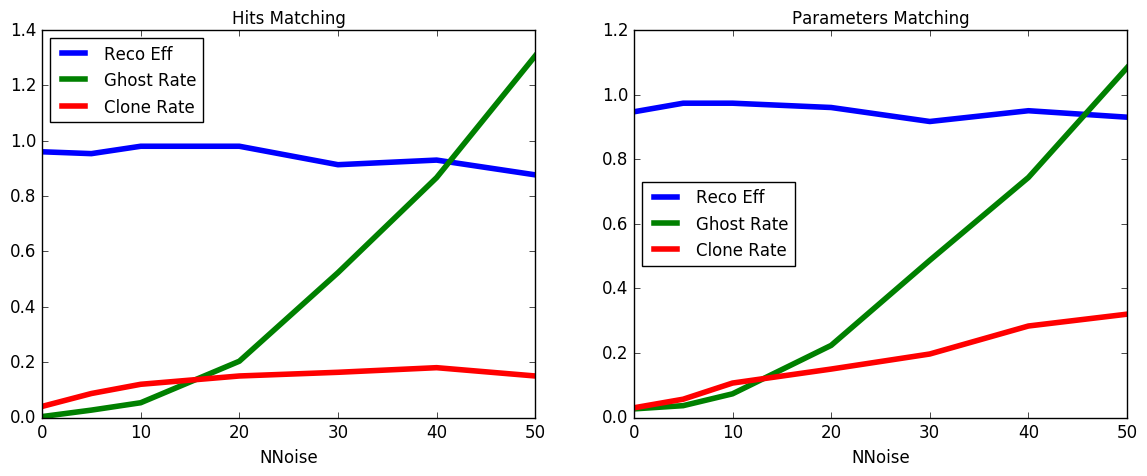

In [477]:
plot_report(report, 'NNoise')

In [479]:
report = pandas.DataFrame(columns=columns)

for n_noise in ns_noise:
    events = straight_tracks_generator(n_events=100, n_tracks=3, n_noise=n_noise, sigma=0.5)
    sk_ransac = RANSACRegressor(min_samples=3, max_trials=100, residual_threshold=0.5)
    ransac = RANSACTracker(n_tracks=3, min_hits=6, regressor=sk_ransac)
    results_ran = get_quality_meatrics(events, model=ransac)
    
    report.loc[len(report)] = [n_noise] + list(results_ran[columns[1:]].mean(axis=0).values)

In [481]:
report

,NNoise,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,0.0,0.943333,0.000000,0.003333,0.936667,0.006667,0.003333
1,5.0,0.950000,0.000000,0.000000,0.950000,0.000000,0.000000
2,10.0,0.926667,0.010000,0.006667,0.910000,0.020000,0.013333
3,20.0,0.830000,0.083333,0.006667,0.830000,0.076667,0.013333
4,30.0,0.756667,0.180000,0.006667,0.770000,0.163333,0.010000
5,40.0,0.640000,0.320000,0.000000,0.670000,0.250000,0.040000
6,50.0,0.510000,0.480000,0.003333,0.620000,0.356667,0.016667


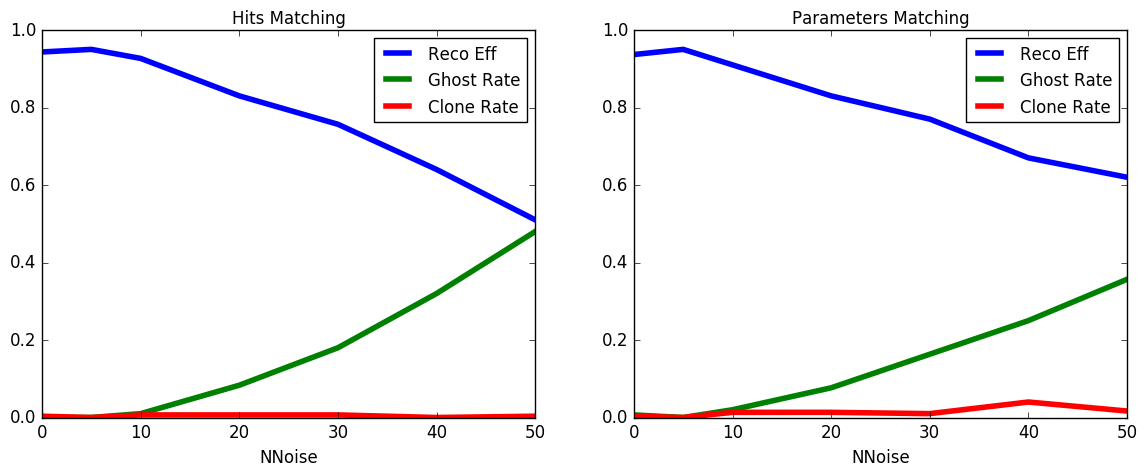

In [482]:
plot_report(report, 'NNoise')

In [527]:
report = pandas.DataFrame(columns=columns)

for n_noise in ns_noise:
    events = straight_tracks_generator(n_events=100, n_tracks=3, n_noise=n_noise, sigma=0.5)
    rt = Retina2DTrackerTwo(n_tracks=3, residuals_threshold=0.5, sigma=0.1, min_hits=6)
    results_rt = get_quality_meatrics(events, model=rt)
    
    report.loc[len(report)] = [n_noise] + list(results_rt[columns[1:]].mean(axis=0).values)

In [484]:
report

,NNoise,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,0.0,0.603333,0.000000,0.010000,0.606667,0.006667,0.000000
1,5.0,0.633333,0.010000,0.010000,0.640000,0.010000,0.003333
2,10.0,0.663333,0.003333,0.016667,0.656667,0.013333,0.013333
3,20.0,0.660000,0.073333,0.006667,0.676667,0.056667,0.006667
4,30.0,0.563333,0.176667,0.003333,0.596667,0.136667,0.010000
5,40.0,0.570000,0.273333,0.000000,0.610000,0.220000,0.013333
6,50.0,0.470000,0.436667,0.000000,0.566667,0.316667,0.023333


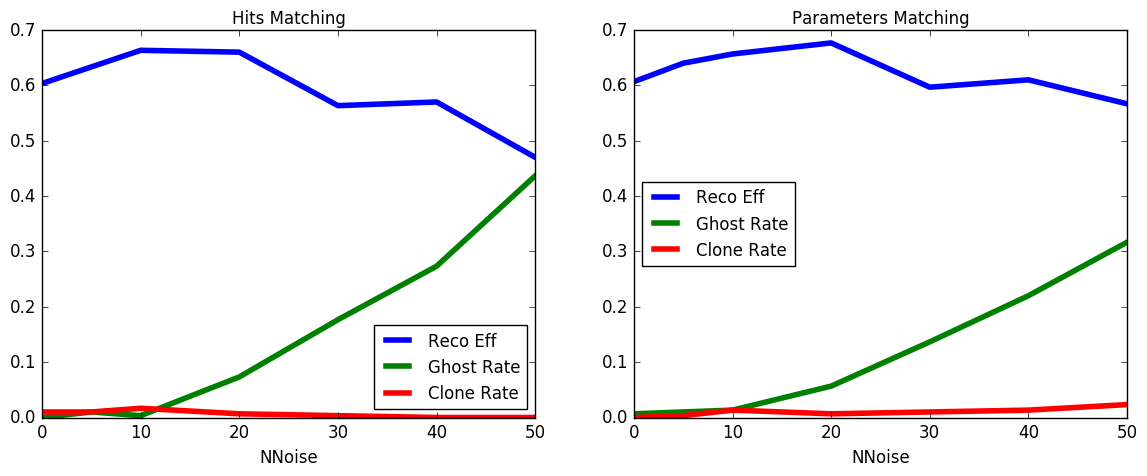

In [485]:
plot_report(report, 'NNoise')

In [546]:
report = pandas.DataFrame(columns=columns)

for n_noise in ns_noise:
    events = straight_tracks_generator(n_events=100, n_tracks=3, n_noise=n_noise, sigma=0.5)
    dp = DenbyPeterson(n_iter=10, 
                   cos_degree=1., 
                   alpha=0.00, 
                   delta=0.00, 
                   temperature=1, 
                   temperature_decay_rate=1., 
                   max_cos=0.9,
                   state_threshold=0.5,
                   min_hits=6,
                   save_stages=True)
    results_dp = get_quality_meatrics(events, model=dp)
    
    report.loc[len(report)] = [n_noise] + list(results_dp[columns[1:]].mean(axis=0).values)

In [547]:
report

,NNoise,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,0.0,0.536667,0.003333,0.000000,0.493333,0.046667,0.000000
1,5.0,0.486667,0.003333,0.003333,0.406667,0.086667,0.000000
2,10.0,0.446667,0.043333,0.010000,0.376667,0.120000,0.003333
3,20.0,0.326667,0.110000,0.013333,0.300000,0.140000,0.010000
4,30.0,0.316667,0.206667,0.000000,0.283333,0.236667,0.003333
5,40.0,0.263333,0.323333,0.003333,0.266667,0.323333,0.000000
6,50.0,0.196667,0.403333,0.003333,0.183333,0.416667,0.003333


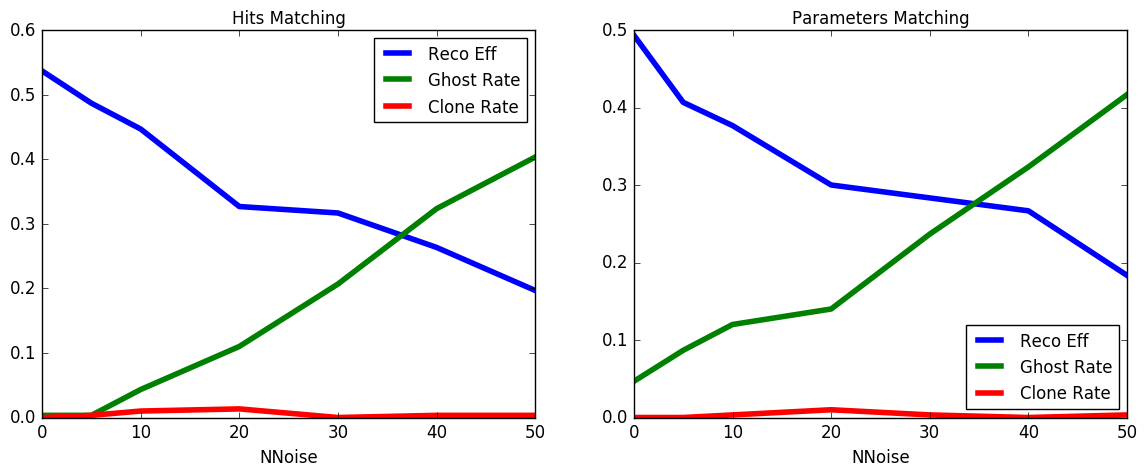

In [548]:
plot_report(report, 'NNoise')

## Task 5 (4 points)

Implement the Linear Hough Transfrom model for the track pattern recognition (finish the following class below). Run it and play with it! Provide the same study for this model which you have done in the tasks 1-4.

In [513]:
class LinearHoughModel(object):
    def __init__(self, k_params=(-2, 2, 0.1), b_params=(-10, 10, 1), min_hits=4, number_tracks = 3):
        self.k_params = k_params
        self.b_params = b_params
        self.min_hits = min_hits
        self.number_tracks = number_tracks
        self.labels_ = None


    def count_params(self, params):
        min, max, step = params
        return int((max - min) / step + 1)

    def fit(self, x, y):
        k_params_num = self.count_params(self.k_params)
        b_params_num = self.count_params(self.b_params)
        k_min, k_max, k_step = self.k_params
        b_min, b_max, b_step = self.b_params

        hist = {}

        for i in range(len(x)):
            x0 = x[i]
            y0 = y[i]
            for k_index in range(k_params_num):

                k = k_min + k_index * k_step
                b = y0 - k * x0
                b_index = int((b - b_min) / b_step)
                if not 0 <= b_index < b_params_num:
                    continue

                if not (k_index, b_index) in hist:
                    hist[(k_index, b_index)] = []

                hist[(k_index, b_index)].append(i)

        cluster_number = 0

        self.labels_ = numpy.full(len(x), -1)

        clusters = []
        
        hist_list = []
    
        for (index, hits) in hist.iteritems():
            hist_list.append((len(hits), index))
            
        hist_list.sort(reverse=True)
    
        for i in range(self.number_tracks):
            (hist_num, index) = hist_list[i]

            (k, b) = index
            clusters.append([k, b])

            for hit in hist[index]:
                self.labels_[hit] = cluster_number

            cluster_number += 1

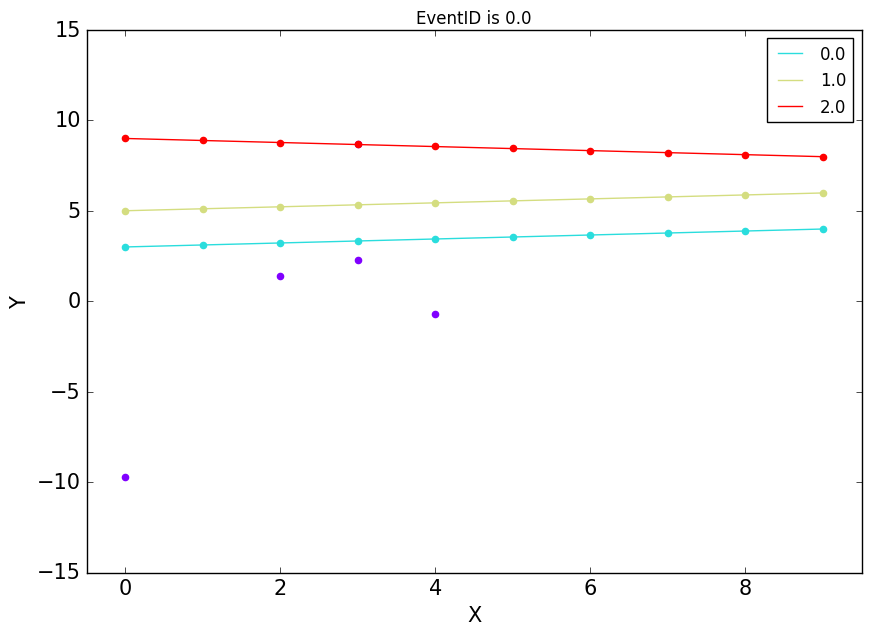

In [517]:
events = straight_tracks_generator(n_events=10, 
                                   n_tracks=3, 
                                   n_noise=5, 
                                   sigma=0.01, 
                                   x_range=(0, 10, 1), 
                                   intersection=False, 
                                   y_range=(0, 10, 1))

event = events[events.EventID == 0]
X = event.X.values
y = event.y.values

plot_straight_tracks(event, labels=None)
plt.xlim(-0.5, 9.5);

In [518]:
lh = LinearHoughModel(number_tracks = 3)
lh.fit(X, y)
labels = lh.labels_

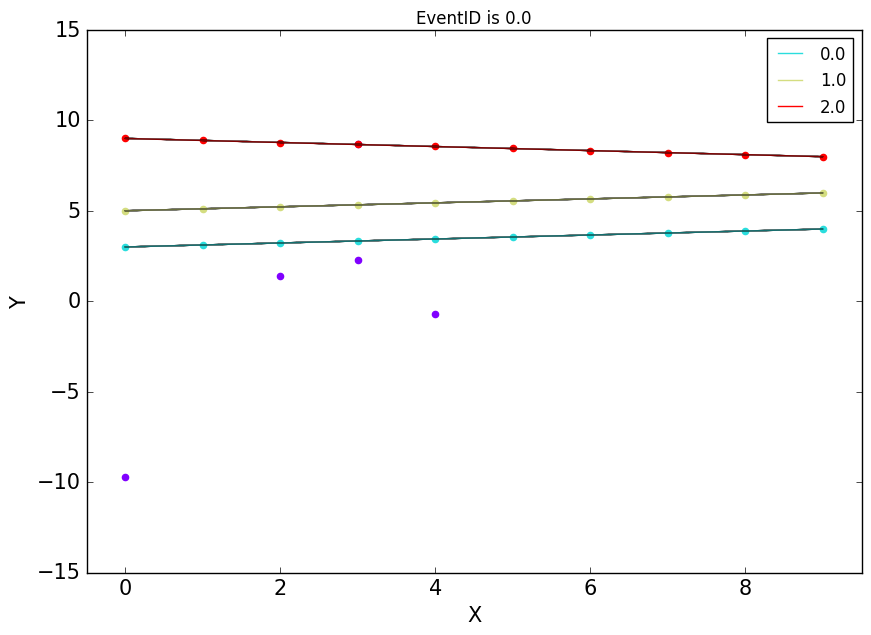

In [519]:
plot_straight_tracks(event, labels)
plt.xlim(-0.5, 9.5);

In [528]:
columns=['sigma', 'HmRecoEff', 'HmGhostRate', 'HmCloneRate', 'PmRecoEff', 'PmGhostRate', 'PmCloneRate']
sigmas = [0.1, 0.5, 1., 2., 3., 4., 5.]
report = pandas.DataFrame(columns=columns)

for sigma in sigmas:
    events = straight_tracks_generator(n_events=100, n_tracks=3, n_noise=10, sigma=sigma)
    lh = LinearHoughModel(number_tracks = 3)
    results_lh = get_quality_meatrics(events, model=lh)
    
    report.loc[len(report)] = [sigma] + list(results_lh[columns[1:]].mean(axis=0).values)

In [529]:
report

,sigma,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,0.1,0.826667,0.056667,0.073333,0.823333,0.056667,0.076667
1,0.5,0.643333,0.050000,0.266667,0.640000,0.123333,0.196667
2,1.0,0.563333,0.140000,0.236667,0.493333,0.296667,0.150000
3,2.0,0.536667,0.256667,0.173333,0.323333,0.563333,0.080000
4,3.0,0.466667,0.343333,0.113333,0.203333,0.640000,0.080000
5,4.0,0.436667,0.370000,0.110000,0.186667,0.693333,0.036667
6,5.0,0.423333,0.426667,0.063333,0.153333,0.733333,0.026667


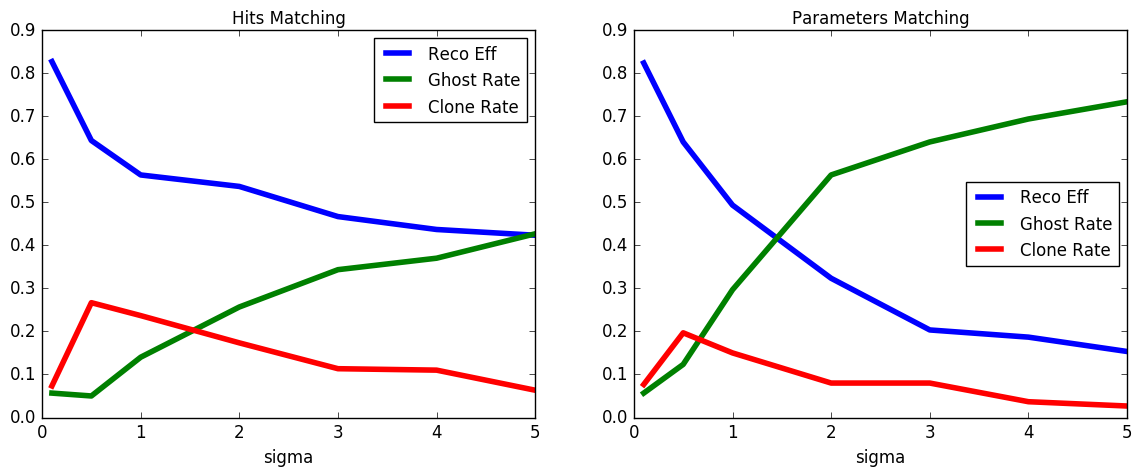

In [530]:
plot_report(report, 'sigma')

In [549]:
columns=['NTracks', 'HmRecoEff', 'HmGhostRate', 'HmCloneRate', 'PmRecoEff', 'PmGhostRate', 'PmCloneRate']
ns_tracks = [1, 2, 3, 4, 5]
report = pandas.DataFrame(columns=columns)

for n_tracks in ns_tracks:
    events = straight_tracks_generator(n_events=100, n_tracks=n_tracks, n_noise=10, sigma=0.5)
    lh = LinearHoughModel(number_tracks = n_tracks)
    results_lh = get_quality_meatrics(events, model=lh)
    
    report.loc[len(report)] = [n_tracks] + list(results_lh[columns[1:]].mean(axis=0).values)

In [550]:
report

,NTracks,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,1.0,1.000000,0.0000,0.0000,0.990,0.010000,0.000000
1,2.0,0.725000,0.0200,0.2550,0.715,0.045000,0.240000
2,3.0,0.663333,0.0700,0.2200,0.670,0.066667,0.216667
3,4.0,0.610000,0.0825,0.2375,0.590,0.132500,0.207500
4,5.0,0.558000,0.1200,0.2420,0.526,0.138000,0.256000


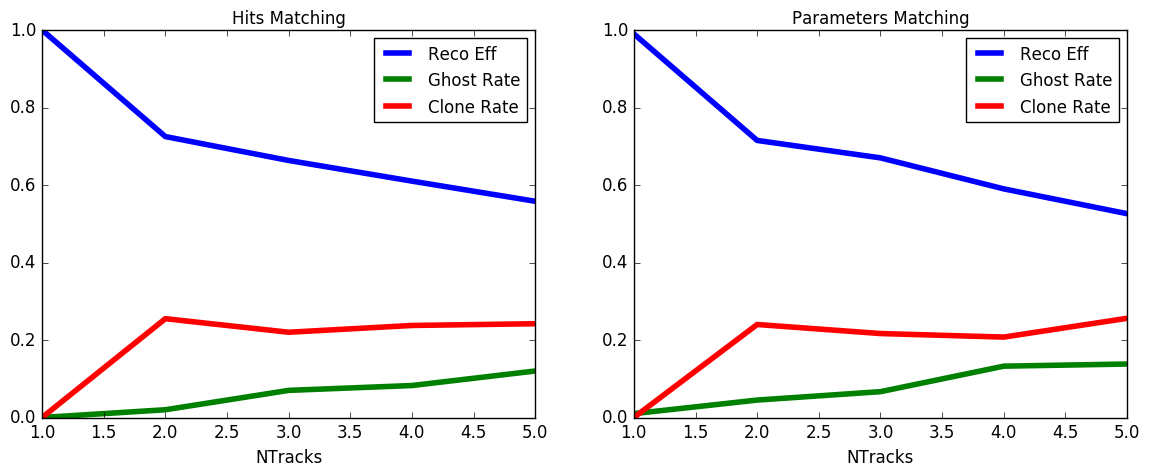

In [551]:
plot_report(report, 'NTracks')

In [542]:
columns=['NNoise', 'HmRecoEff', 'HmGhostRate', 'HmCloneRate', 'PmRecoEff', 'PmGhostRate', 'PmCloneRate']
ns_noise = [0, 5, 10, 20, 30, 40, 50]
report = pandas.DataFrame(columns=columns)

for n_noise in ns_noise:
    events = straight_tracks_generator(n_events=100, n_tracks=3, n_noise=n_noise, sigma=0.5)
    lh = LinearHoughModel(number_tracks = 3)
    results_lh = get_quality_meatrics(events, model=lh)
    
    report.loc[len(report)] = [n_noise] + list(results_lh[columns[1:]].mean(axis=0).values)

In [543]:
report

,NNoise,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,0.0,0.706667,0.010000,0.240000,0.676667,0.103333,0.176667
1,5.0,0.686667,0.010000,0.270000,0.676667,0.070000,0.220000
2,10.0,0.650000,0.076667,0.253333,0.643333,0.096667,0.240000
3,20.0,0.633333,0.143333,0.206667,0.623333,0.123333,0.236667
4,30.0,0.573333,0.230000,0.156667,0.593333,0.146667,0.220000
5,40.0,0.530000,0.333333,0.120000,0.550000,0.213333,0.220000
6,50.0,0.490000,0.386667,0.100000,0.493333,0.276667,0.206667


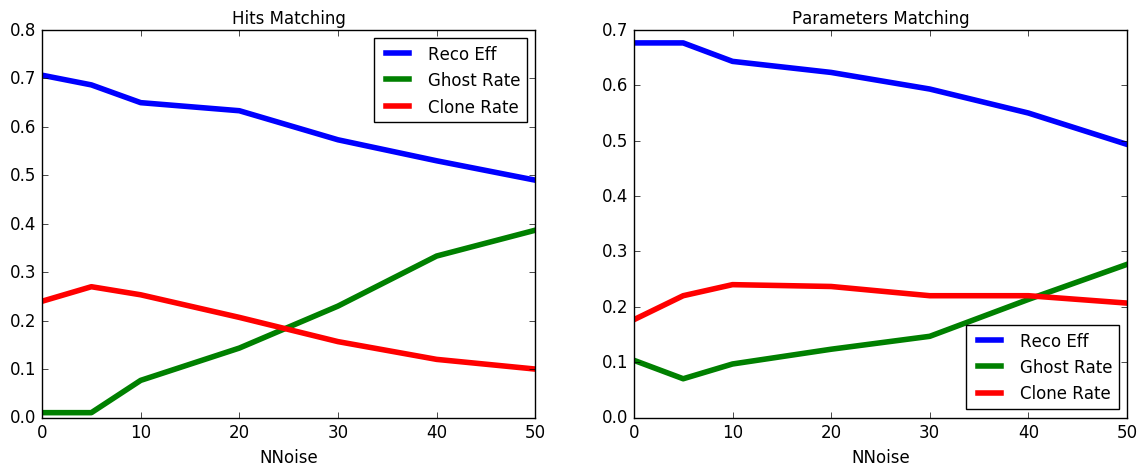

In [544]:
plot_report(report, 'NNoise')